## Project, Part 1: Designing a Switched-Resistor Passive Balancing System


### Concept


### Deliverables
The goal of Part 1 of the capstone project is to hand-tune a resistance value to use in a switched-resistor passive balancing system. If this resistance is too low, balancing power dissipated by the resistor will be high, resulting in the need for larger (and more expensive) resistor and transistor components. Further, the total heat generated by all balancers in the pack will be high, resulting in a need for a bigger (and more expensive) thermal-management system. But, balancing will be fast. On the other hand, if the resistance is too high, balancing will be slow. So, there is a design tradeoff that must be satisfied when choosing the balancing resistance.

I have created a dataset representing an out-of-balance battery pack that you will use to test your balancing design. This dataset was created using the code from Lessons 5.2.4 and 5.2.5. I simulated more than 200h of real time on a 100-cell battery pack having mismatched cells. This represents more than 3,000 miles (around 5,000 km) of vehicle driving plus multiple battery-pack charging events -- all without balancing! So, if we are able to balance this battery pack in less than 36h, we are doing well enough. 

I have provided code to you that loads this dataset, and is able to execute up to 36h of balancing on the dataset if you provide a balancing-resistance value. The code is very similar to what I shared with you in Lessons 5.2.4 and 5.2.5, except that the external battery-pack current is zero while balancing, and balancing is "turned on". The balancing strategy is based on cell terminal voltage -- cells are "balanced" whenever their terminal voltage is more than 2mV greater than the minimum terminal voltage of all 100 cells in the battery pack. 

Your deliverable will be a single resistance value within the <code>tuneBalancer</code> function, below.

## Implementation of switched-resistor passive balancing
This remainder of this notebook implements a switched-resistor passive balancing simulation.

In [1]:
% First, make sure that the ESC toolbox functions are in the path
addpath readonly
load ./readonly/E2model; % The ESC model of the cell used for this project

The following code loads the unbalanced cell data, and plots a histogram of cell SOC values so you can see how out-of-balance the battery pack is before you balance it.

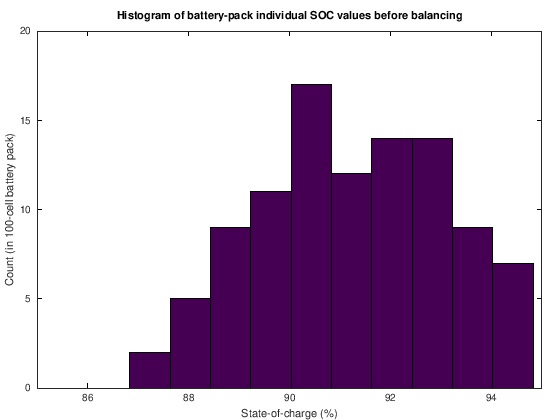

In [2]:
load ./readonly/packData
hist(100*packData.storez); % Plot histogram of cell SOC in this pack (in percent)
title('Histogram of battery-pack individual SOC values before balancing');
xlabel('State-of-charge (%)'); ylabel('Count (in 100-cell battery pack)');
xlim([85 95])

The following is the balancing simulation. (Do not change this function.)

In [3]:
% function [storez_output,pk,maxpk,tbal] = cellBalance(packData,model,Rbal)
%
% - packData - Contains parameter data for all cells before balancing
% - model    - The ESC model for the cell used in the battery pack
% - Rbal     - The balancing resistance you have chosen for this design
%
% - storez_output - The final SOC values for each cell after balancing
% - pk            - The total power dissipated by all balacing resistors
%                   in the pack as a function of time (in W)
% - maxpk         - The maximum power dissipated by any individual balancing 
%                   resistor in the pack as a function of time (in W)
% - tbal          - The time taken to balance the pack to within 2mV (in s)
% - storeV        - All cell voltages versus time... note that cells have
%                   different self-discharge rates, different leakage current,
%                   etc, so will decrease in voltage even when not being 
%                   balanced actively.
function [storez_output,pk,maxpk,tbal,saveV] = cellBalance(packData,model,Rbal)
  % ------------------------------------------------------------------------
  % Initialize some simulation configuration parameters ...
  % ------------------------------------------------------------------------
  maxtime = 36*3600; % Maximum simulation run time in simulated seconds
  pk = zeros(maxtime,1);
  maxpk = zeros(maxtime,1);
  saveV = zeros(length(packData.storez),maxtime);
  
  % ------------------------------------------------------------------------
  % Initialize states for ESC cell model. These values came from instructor-
  % executed code that simulated more than 200h of drive cycles and charging
  % (without balancing)... these are the final states of those cells after
  % that simulation, and so are the initial states of these cells before
  % balancing.
  % ------------------------------------------------------------------------
  z = packData.storez;
  irc = packData.storeirc;
  
  % ------------------------------------------------------------------------
  % Default initialization for cells within the pack
  % ------------------------------------------------------------------------
  T = packData.T;       % Temperature for each cell, assumed to be constant
  Tsd = packData.Tsd;   % Self-discharge "temperature" for each cell
  leak = packData.leak; % Leakage current for each cell
  q = packData.q;       % Total capacity for each cell (all may be different)
  rc = packData.rc;     % R-C time constant for each cell
  r = packData.r;       % Diffusion-resistor values for each cell
  r0 = packData.r0;     % Series resistance values for each cell
  
  % ------------------------------------------------------------------------
  
  % ------------------------------------------------------------------------
  for k = 1: maxtime
    % Calculate cell voltages
    v = OCVfromSOCtemp(z,T,model); % get OCV for each cell
    v = v - r.*irc; % add in capacitor voltages (ignore hysteresis to simplify sim)
    saveV(:,k) = v(:); % save all cells' terminal voltage for later analysis
    % Cell Simulation
    ik = zeros(size(v)); % no string current
    % Simulate self discharge via variable resistor in parallel
    rsd = ((-20+0.4*Tsd).*z + (35-0.5*Tsd))*1e3; ik = ik + v./rsd;
    % Simulate leakage current
    ik = ik + leak;
    % Check to see which cells are 2mV or more above minimum cell voltage
    checkBalance = (v - min(v)) - 2e-3 >= 0;
    if sum(checkBalance) == 0, % balancing is complete, so return
      saveV = saveV(:,1:k-1);
      pk = pk(1:k-1);
      maxpk = maxpk(1:k-1);
      tbal = k-1;
      storez_output = z; % Output only final SOC for each cell after 4 hours of simulation time
      return
    end
    % cells 2mV or more from the minimum will have array value 1, otherwise 0
    % Add balancing resistors and calculate resulting cell current
    v_balance = v.*checkBalance;
    % Set non-balance cell voltage to 0 for calculation (to ensure balance current = 0 for no-balance cells)
    i_balance = (v_balance./Rbal); % Current calculated for balance cell, with parallel resistor 
    ik = ik + i_balance; % Add balance current to externally applied cell current
    
    % Compute power
    pk(k) = sum(i_balance.^2*Rbal);    % total power dissipated by all cells being balanced in pack 
    maxpk(k) = max(i_balance.^2*Rbal); % maximum single-cell power dissipated
    % Calculate new SOC for each cell
    z = z - (1/3600)*ik./q; % Update each cell SOC
    % Update diffusion-resistor currents
    irc = rc.*irc + (1-rc).*ik; % Update capacitor voltages
    if mod(k,3600) == 0,
      fprintf('Completed %dh balancing (%d "unbalanced" cells remain).\n',round(k/3600),sum(checkBalance));
    end
  end % for k
  % If we get to this point, then must have balanced for more than 200h (not good)
  tbal = k;
  storez_output = z; % Output only final SOC for each cell 
end

The following code provides the tuning values for the balancing resistance. You will design the balancer by changing the value returned by this function. 

Every time you make a change to the balancing resistance, make sure that you type < shift >< enter > in this code, and then also press < shift >< enter > in the "wrapper code", below, that executes the balancing algorithm.

Hint: Since maximum cell voltage is around 4.2V, and since 
$$\mbox{cell power} = V^{2}/\mbox{rBalance},$$
you should be able to guess a pretty good value for balancing resistance before you perform any simulations. Also, since maximum power dissipated by all cells in a 100-cell battery pack occurs when 99 cells are above the minimum voltage, 
$$\mbox{maximum pack power} = 99 V^{2}/\mbox{rBalance}.$$ 
This should be helpful information too for finding an initial value of balancing resistance, which you can then refine.

In [4]:


% function rBalance = tuneBalancer
%
% rBalance - the value you choose for your design

function rBalance = tuneBalancer

  % BEGIN MODIFYING CODE AFTER THIS
  rBalance = 170; % [ohms] ... This is a sample value. You will need to change it.
end  

The following "wrapper" code loads a lab-test data file, runs the EKF, and plots results. Make sure you type < shift >< enter> in the earlier "helper function" notebook cells before executing the "wrapper code".  (Do not change this code.)

Completed 1h balancing (98 "unbalanced" cells remain).
Completed 2h balancing (96 "unbalanced" cells remain).
Completed 3h balancing (94 "unbalanced" cells remain).
Completed 4h balancing (92 "unbalanced" cells remain).
Completed 5h balancing (89 "unbalanced" cells remain).
Completed 6h balancing (84 "unbalanced" cells remain).
Completed 7h balancing (80 "unbalanced" cells remain).
Completed 8h balancing (76 "unbalanced" cells remain).
Completed 9h balancing (69 "unbalanced" cells remain).
Completed 10h balancing (62 "unbalanced" cells remain).
Completed 11h balancing (55 "unbalanced" cells remain).
Completed 12h balancing (49 "unbalanced" cells remain).
Completed 13h balancing (48 "unbalanced" cells remain).
Completed 14h balancing (42 "unbalanced" cells remain).
Completed 15h balancing (36 "unbalanced" cells remain).
Completed 16h balancing (31 "unbalanced" cells remain).
Completed 17h balancing (26 "unbalanced" cells remain).
Completed 18h balancing (23 "unbalanced" cells remain).
C

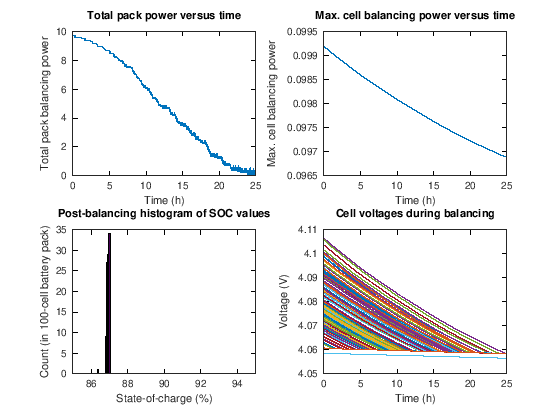

In [5]:
rBalance = tuneBalancer;
[storez_output,pk,maxpk,tbal,saveV] = cellBalance(packData,model,rBalance);

t = 1:length(pk);
subplot(2,2,1);
plot(t/3600,pk); xlabel('Time (h)'); ylabel('Total pack balancing power'); 
title('Total pack power versus time');

subplot(2,2,2)
plot(t/3600,maxpk); xlabel('Time (h)'); ylabel('Max. cell balancing power'); 
title('Max. cell balancing power versus time');

subplot(2,2,3)
hist(100*storez_output); % Plot histogram of post-balancing cell SOC in this pack (in percent)
title('Post-balancing histogram of SOC values'); xlabel('State-of-charge (%)');
ylabel('Count (in 100-cell battery pack)'); xlim([85 95]);

subplot(2,2,4)
plot(t/3600,saveV'); % Plot trace of all cell voltages over time
title('Cell voltages during balancing'); xlabel('Time (h)'); ylabel('Voltage (V)');

fprintf('During balancing, maximum pack balancing power was %fW (should be less than 10W)\n',max(pk));
fprintf('During balancing, maximum cell balancing power was %fW (should be less than 0.1W)\n',max(maxpk));
fprintf('Time to balance was %fh (should be less than 29.5h)\n',tbal/3600);

% Compute expected grade
grade = [];
if (max(pk) <= 10) && max(maxpk) <= 0.1 && tbal/3600 < 32.5,
  grade = max(0,min(10,find((29.5:-0.5:22)<tbal/3600,1,'first') - 1));
end
if isempty(grade), grade = 0; end
fprintf(['If you submit the assignment with this balancing resistance,\n' ...
          '  you should expect to receive a grade of %d/10\n'],grade);


When you are satisfied with your tuning, click on the "<b>Submit Assignment</b>" button, above.

The assignment will be graded out of a maximum of 10 points possible. 
* If your code produces errors when executed, the grade is zero
* If total balancing power is ever greater than 10W, the grade is zero
* If any individual cell's balancing power is ever greater than 0.1W, the grade is zero
* Otherwise, your grade can be found looking up the total balancing time in the grading table given in the project description page (the value is also computed by this code, for easy reference).
 * For a grade of 100%, you will need to achieve balancing time less than 25h.